# 04 Model Pipeline

Since we found out in the previous notebook that a linear regression has an $R^{2}$ of over 0.9,
we'll focus in making a pipeline for easier integration.

We will spend waste time with hyper-parameter tuning due to the results previously observed with a linear regression or Catboost. Plus, CatBoost also performs a self optimization during the training phase.

In [1]:
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    mean_squared_error
)

%matplotlib inline

In [2]:
journeys = pd.read_csv('../data/journeys.csv')

In [3]:
journeys['Trip Start At Local Time'] = pd.to_datetime(journeys['Trip Start At Local Time'])
journeys['Trip End At Local Time'] = pd.to_datetime(journeys['Trip End At Local Time'])

In [4]:
journeys['duration'] = journeys['Trip End At Local Time'] - journeys['Trip Start At Local Time']

In [5]:
journeys['duration'] = journeys['duration'].astype('timedelta64[h]')

In [6]:
journeys['date'] = journeys['Trip Start At Local Time'].dt.date
journeys['time'] = journeys['Trip Start At Local Time'].dt.time

In [7]:
journeys['datetime'] = journeys['Trip Start At Local Time'].copy()

In [8]:
journeys['city'] = journeys['Car Parking Address City'].copy()

In [9]:
journeys['trip_price'] = (
    journeys['Trip Sum Trip Price']
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
    .astype(float)
)

In [10]:
X_cols = ['city', 'datetime', 'duration']
y_col = 'trip_price'

In [11]:
X = journeys[X_cols].copy()
y = journeys[y_col].copy()

In [12]:
X.head()

,city,datetime,duration
0,San Francisco,2017-11-14 22:15:00,4.0
1,San Francisco,2017-12-07 17:00:00,11.0
2,San Francisco,2017-03-23 10:00:00,2.0
3,San Francisco,2017-07-05 19:00:00,6.0
4,Boston,2017-01-24 09:00:00,2.0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
class DataFrameSelect(BaseEstimator, TransformerMixin):
    
    def __init__(self, column_names):
        self.column_names = column_names
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.column_names]
    
class DateTimeHandler(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, x, y=None):
        return self

    def transform(self, x):
        date_serie = pd.to_datetime(x)
        features = []
        features.append(date_serie.dt.month)
        features.append(date_serie.dt.day)
        features.append(date_serie.dt.weekday)
        features.append(date_serie.dt.hour)
        features.append(date_serie.dt.minute)
        df = pd.concat(features, axis=1)
        df.columns = ['month', 'day', 'weekday', 'hour', 'minute']

        return df

In [15]:
dates_pipe = Pipeline(
    [
        ('date_selector', DataFrameSelect('datetime')),
        ('handler', DateTimeHandler()),
    ]
)
city_pipe = Pipeline(
    [
        ('city_selector', DataFrameSelect(['city']))
    ]
)
union = FeatureUnion(
    [
        ('dates', dates_pipe),
        ('cities', city_pipe)
    ]
)
categoricals = Pipeline(
    [
        ('union', union),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ]
)
full_pipe = FeatureUnion(
    [
        ('cats', categoricals),
        ('duration', DataFrameSelect(['duration']))
    ]
)
model = Pipeline(
    [
        ('pipe', full_pipe),
        ('cat', CatBoostRegressor())
    ]
)

In [16]:
model.fit(X_train, y_train)

Learning rate set to 0.076046
0:	learn: 58.7593727	total: 64.2ms	remaining: 1m 4s
1:	learn: 55.4312757	total: 69.9ms	remaining: 34.9s
2:	learn: 52.4995097	total: 75.3ms	remaining: 25s
3:	learn: 49.7444205	total: 79.9ms	remaining: 19.9s
4:	learn: 47.1502628	total: 83.9ms	remaining: 16.7s
5:	learn: 44.7850235	total: 87.5ms	remaining: 14.5s
6:	learn: 42.5565502	total: 90.7ms	remaining: 12.9s
7:	learn: 40.6248410	total: 93.6ms	remaining: 11.6s
8:	learn: 38.8058365	total: 97.2ms	remaining: 10.7s
9:	learn: 37.0871756	total: 100ms	remaining: 9.92s
10:	learn: 35.5061835	total: 104ms	remaining: 9.31s
11:	learn: 34.0565554	total: 106ms	remaining: 8.76s
12:	learn: 32.7430989	total: 109ms	remaining: 8.29s
13:	learn: 31.4991160	total: 112ms	remaining: 7.92s
14:	learn: 30.3891410	total: 116ms	remaining: 7.58s
15:	learn: 29.3972562	total: 119ms	remaining: 7.31s
16:	learn: 28.4819121	total: 122ms	remaining: 7.03s
17:	learn: 27.6196772	total: 124ms	remaining: 6.79s
18:	learn: 26.8576585	total: 128ms	re

Pipeline(steps=[('pipe',
                 FeatureUnion(transformer_list=[('cats',
                                                 Pipeline(steps=[('union',
                                                                  FeatureUnion(transformer_list=[('dates',
                                                                                                  Pipeline(steps=[('date_selector',
                                                                                                                   DataFrameSelect(column_names='datetime')),
                                                                                                                  ('handler',
                                                                                                                   DateTimeHandler())])),
                                                                                                 ('cities',
                                                                          

In [17]:
y_hat = model.predict(X_test)

In [18]:
def regression_metrics(y_true, y_pred):
    return pd.Series(
        {
            'MAE': mean_absolute_error(y_true, y_pred),
            'MSE': mean_squared_error(y_true, y_pred),
            'RMSE': sqrt(mean_squared_error(y_true, y_pred)),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred),
            'R2': r2_score(y_true, y_pred)
        }
    )

In [19]:
train = regression_metrics(y_train, model.predict(X_train))
train.name = 'train'
test = regression_metrics(y_test, y_hat)
test.name = 'test'
results = pd.concat([train, test], axis=1)

In [20]:
results

,train,test
MAE,7.624601,8.474849
MSE,151.324124,273.092054
RMSE,12.301387,16.525497
MAPE,0.172942,0.178579
R2,0.961078,0.922989


In [21]:
resid = y_test - y_hat

In [22]:
def plot_resid(y_true, y_pred, title):
    resid = y_true - y_pred
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        y=resid,
        x=y_pred
    );
    plt.axhline(resid.mean(), color='r');
    plt.xlabel('$\hat{y}$');
    plt.ylabel('u');
    plt.title(title);
    plt.legend(['residuals', 'mean'])

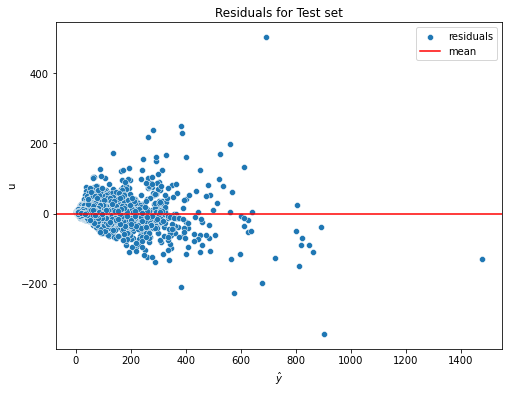

In [23]:
plot_resid(y_test, y_hat, 'Residuals for Test set')

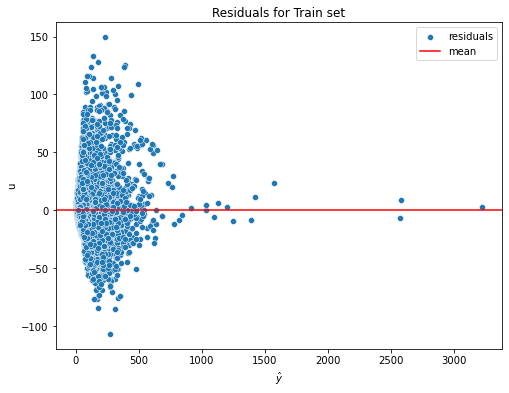

In [24]:
plot_resid(y_train,model.predict(X_train), 'Residuals for Train set')

In [25]:

with open('../models/price_model.pkl', 'wb') as f:
    pickle.dump(model, f)